We are introducing different normalization techniques in the code that gave 99.4% acccuracy.
1. Layer Normaization
2. Group Normalization
3. Batch Normalization along with L1 regularization

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [ ]:
## CONSTANTS
SEED=42
DROPOUT_VALUE = 0.1
NUM_GROUPS_FOR_GN = 2
LAMBDA=5e-4
EPOCHS=20

## Data Transformations



In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
#SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
#dropout_value = DROPOUT_VALUE
#num_groups = NUM_GROUPS_FOR_GN

class Net(nn.Module):
    def __init__(self,use_norm):
        super(Net, self).__init__()
        self.use_norm=use_norm
        # Input Block
        
        if self.use_norm=='BATCH':
          norm1=nn.BatchNorm2d(14) ## adding self.norm1 adds the paramtere two times
        elif self.use_norm=='LAYER':
          norm1=nn.LayerNorm([14,26,26])
        else:# self.use_norm=='GROUP':
          norm1=nn.GroupNorm (NUM_GROUPS_FOR_GN,14)

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            norm1,
            nn.Dropout(DROPOUT_VALUE)
        ) # output_size = 26

        
        # CONVOLUTION BLOCK 1
        
        if self.use_norm=='BATCH':
          norm2=nn.BatchNorm2d(28)
        elif self.use_norm=='LAYER':
          norm2=nn.LayerNorm([28,24,24])
        elif self.use_norm=='GROUP':
          norm2=nn.GroupNorm (NUM_GROUPS_FOR_GN,28)


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            norm2,
            nn.Dropout(DROPOUT_VALUE)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        if self.use_norm=='BATCH':
          norm3=nn.BatchNorm2d(14)
          norm4=nn.BatchNorm2d(12)
          norm5=nn.BatchNorm2d(12)
          norm6=nn.BatchNorm2d(12)
        
        elif self.use_norm=='LAYER':
          norm3=nn.LayerNorm([14,10,10])
          norm4=nn.LayerNorm([12,8,8])
          norm5=nn.LayerNorm([12,6,6])
          norm6=nn.LayerNorm([12,6,6])
          
        elif self.use_norm=='GROUP':
          norm3=nn.GroupNorm (NUM_GROUPS_FOR_GN,14)
          norm4=nn.GroupNorm (NUM_GROUPS_FOR_GN,12)
          norm5=nn.GroupNorm (NUM_GROUPS_FOR_GN,12)
          norm6=nn.GroupNorm (NUM_GROUPS_FOR_GN,12)
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            norm3,
            nn.Dropout(DROPOUT_VALUE)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            norm4,
            nn.Dropout(DROPOUT_VALUE)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            norm5,
            nn.Dropout(DROPOUT_VALUE)
        ) # output_size = 6

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            norm6,
            nn.Dropout(DROPOUT_VALUE)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(DROPOUT_VALUE)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
model = Net("GROUP").to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
         GroupNorm-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 28, 24, 24]           3,528
              ReLU-6           [-1, 28, 24, 24]               0
         GroupNorm-7           [-1, 28, 24, 24]              56
           Dropout-8           [-1, 28, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             336
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,512
             ReLU-12           [-1, 14, 10, 10]               0
        GroupNorm-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1, 14,

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer,use_L1_regularization,epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    nll_loss = F.nll_loss(y_pred, target)
    
    
    ## only in case of Batch Normalization
    if use_L1_regularization==True:
      #print("using the L1 regularization")
      reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])
      loss= nll_loss + LAMBDA * reg_loss
    else:
      loss = nll_loss


    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=15)
lstNorms=['LAYER','BATCH','GROUP']
modelNamePrefix="normalizationModels_"
train_losses_dict = {}
test_losses_dict = {}
train_acc_dict = {}
test_acc_dict = {}
use_L1_regularization=False

for norm in lstNorms:
  print("******** using the "+ norm+" noramlization technique ************")
  model =  Net(norm).to(device)
  ## oprimizerr & Scheduler
  optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  
  ## variables to hold the losses & accuracy
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      print('LR:', scheduler.get_last_lr())
      if(norm=="BATCH"):
        use_L1_regularization=True      
      train(model, device, train_loader, optimizer,use_L1_regularization, epoch)
      test(model, device, test_loader)
      scheduler.step()
  torch.save(model,"/content/drive/MyDrive/Colab_Notebooks/EVA8/normalizationTechniques/Models/"+modelNamePrefix+"_"+norm)
  del model
  
  t=[t.cpu().item() for t in train_losses]
  train_losses_dict[norm]=t
  test_losses_dict[norm]=test_losses
  train_acc_dict[norm]=train_acc
  test_acc_dict[norm]=test_acc



******** using the LAYER noramlization technique ************
EPOCH: 0
LR: [0.3]


Loss=0.22626465559005737 Batch_id=468 Accuracy=77.98: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]



Test set: Average loss: 0.0790, Accuracy: 9760/10000 (97.60%)

EPOCH: 1
LR: [0.3]


Loss=0.11765030771493912 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]



Test set: Average loss: 0.0556, Accuracy: 9824/10000 (98.24%)

EPOCH: 2
LR: [0.3]


Loss=0.007235234137624502 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0416, Accuracy: 9856/10000 (98.56%)

EPOCH: 3
LR: [0.3]


Loss=0.11486471444368362 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0349, Accuracy: 9881/10000 (98.81%)

EPOCH: 4
LR: [0.3]


Loss=0.051535412669181824 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]



Test set: Average loss: 0.0311, Accuracy: 9890/10000 (98.90%)

EPOCH: 5
LR: [0.3]


Loss=0.03165706992149353 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0298, Accuracy: 9895/10000 (98.95%)

EPOCH: 6
LR: [0.03]


Loss=0.007086919154971838 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]



Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

EPOCH: 7
LR: [0.03]


Loss=0.01484385784715414 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]



Test set: Average loss: 0.0205, Accuracy: 9929/10000 (99.29%)

EPOCH: 8
LR: [0.03]


Loss=0.012306914664804935 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]



Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.33%)

EPOCH: 9
LR: [0.03]


Loss=0.009797348640859127 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]



Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 10
LR: [0.03]


Loss=0.004552229307591915 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]



Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 11
LR: [0.03]


Loss=0.011729537509381771 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]



Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 12
LR: [0.003]


Loss=0.03101567178964615 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]



Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 13
LR: [0.003]


Loss=0.014491314999759197 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 14
LR: [0.003]


Loss=0.030695565044879913 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]



Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 15
LR: [0.003]


Loss=0.011373248882591724 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]



Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 16
LR: [0.003]


Loss=0.013846561312675476 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

EPOCH: 17
LR: [0.003]


Loss=0.04154449328780174 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]



Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

EPOCH: 18
LR: [0.00030000000000000003]


Loss=0.016954312101006508 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 19
LR: [0.00030000000000000003]


Loss=0.014199892990291119 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

******** using the BATCH noramlization technique ************
EPOCH: 0
LR: [0.3]


Loss=0.47451841831207275 Batch_id=468 Accuracy=91.41: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]



Test set: Average loss: 0.1825, Accuracy: 9402/10000 (94.02%)

EPOCH: 1
LR: [0.3]


Loss=0.472154438495636 Batch_id=468 Accuracy=94.87: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]



Test set: Average loss: 0.1115, Accuracy: 9649/10000 (96.49%)

EPOCH: 2
LR: [0.3]


Loss=0.4263608157634735 Batch_id=468 Accuracy=95.01: 100%|██████████| 469/469 [00:18<00:00, 25.39it/s]



Test set: Average loss: 0.1639, Accuracy: 9441/10000 (94.41%)

EPOCH: 3
LR: [0.3]


Loss=0.39421844482421875 Batch_id=468 Accuracy=95.23: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]



Test set: Average loss: 0.1211, Accuracy: 9614/10000 (96.14%)

EPOCH: 4
LR: [0.3]


Loss=0.3640294671058655 Batch_id=468 Accuracy=95.09: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]



Test set: Average loss: 0.1399, Accuracy: 9567/10000 (95.67%)

EPOCH: 5
LR: [0.3]


Loss=0.3777469992637634 Batch_id=468 Accuracy=95.29: 100%|██████████| 469/469 [00:18<00:00, 25.43it/s]



Test set: Average loss: 0.1198, Accuracy: 9627/10000 (96.27%)

EPOCH: 6
LR: [0.03]


Loss=0.5041921734809875 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0508, Accuracy: 9841/10000 (98.41%)

EPOCH: 7
LR: [0.03]


Loss=0.26594382524490356 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.0463, Accuracy: 9851/10000 (98.51%)

EPOCH: 8
LR: [0.03]


Loss=0.28028208017349243 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:18<00:00, 25.22it/s]



Test set: Average loss: 0.0583, Accuracy: 9813/10000 (98.13%)

EPOCH: 9
LR: [0.03]


Loss=0.27756088972091675 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]



Test set: Average loss: 0.0666, Accuracy: 9779/10000 (97.79%)

EPOCH: 10
LR: [0.03]


Loss=0.26132896542549133 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]



Test set: Average loss: 0.0737, Accuracy: 9755/10000 (97.55%)

EPOCH: 11
LR: [0.03]


Loss=0.22757922112941742 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]



Test set: Average loss: 0.0790, Accuracy: 9769/10000 (97.69%)

EPOCH: 12
LR: [0.003]


Loss=0.1861853450536728 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]



Test set: Average loss: 0.0377, Accuracy: 9888/10000 (98.88%)

EPOCH: 13
LR: [0.003]


Loss=0.21851131319999695 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]



Test set: Average loss: 0.0366, Accuracy: 9887/10000 (98.87%)

EPOCH: 14
LR: [0.003]


Loss=0.20470254123210907 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]



Test set: Average loss: 0.0350, Accuracy: 9890/10000 (98.90%)

EPOCH: 15
LR: [0.003]


Loss=0.17142538726329803 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0356, Accuracy: 9897/10000 (98.97%)

EPOCH: 16
LR: [0.003]


Loss=0.24000966548919678 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:18<00:00, 25.71it/s]



Test set: Average loss: 0.0375, Accuracy: 9883/10000 (98.83%)

EPOCH: 17
LR: [0.003]


Loss=0.17039190232753754 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]



Test set: Average loss: 0.0386, Accuracy: 9881/10000 (98.81%)

EPOCH: 18
LR: [0.00030000000000000003]


Loss=0.16440097987651825 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:18<00:00, 25.43it/s]



Test set: Average loss: 0.0365, Accuracy: 9887/10000 (98.87%)

EPOCH: 19
LR: [0.00030000000000000003]


Loss=0.174587681889534 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]



Test set: Average loss: 0.0356, Accuracy: 9893/10000 (98.93%)

******** using the GROUP noramlization technique ************
EPOCH: 0
LR: [0.3]


Loss=0.5795656442642212 Batch_id=468 Accuracy=84.30: 100%|██████████| 469/469 [00:19<00:00, 24.56it/s]



Test set: Average loss: 0.1682, Accuracy: 9507/10000 (95.07%)

EPOCH: 1
LR: [0.3]


Loss=0.5233907699584961 Batch_id=468 Accuracy=93.33: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]



Test set: Average loss: 0.1220, Accuracy: 9624/10000 (96.24%)

EPOCH: 2
LR: [0.3]


Loss=0.47963747382164 Batch_id=468 Accuracy=93.81: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]



Test set: Average loss: 0.1138, Accuracy: 9641/10000 (96.41%)

EPOCH: 3
LR: [0.3]


Loss=0.4662612974643707 Batch_id=468 Accuracy=94.11: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]



Test set: Average loss: 0.1052, Accuracy: 9686/10000 (96.86%)

EPOCH: 4
LR: [0.3]


Loss=0.48432886600494385 Batch_id=468 Accuracy=94.24: 100%|██████████| 469/469 [00:18<00:00, 24.91it/s]



Test set: Average loss: 0.1117, Accuracy: 9674/10000 (96.74%)

EPOCH: 5
LR: [0.3]


Loss=0.5958213806152344 Batch_id=468 Accuracy=94.31: 100%|██████████| 469/469 [00:18<00:00, 24.94it/s]



Test set: Average loss: 0.1745, Accuracy: 9538/10000 (95.38%)

EPOCH: 6
LR: [0.03]


Loss=0.4063910245895386 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]



Test set: Average loss: 0.0459, Accuracy: 9856/10000 (98.56%)

EPOCH: 7
LR: [0.03]


Loss=0.33879685401916504 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]



Test set: Average loss: 0.0484, Accuracy: 9845/10000 (98.45%)

EPOCH: 8
LR: [0.03]


Loss=0.24777594208717346 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]



Test set: Average loss: 0.0646, Accuracy: 9794/10000 (97.94%)

EPOCH: 9
LR: [0.03]


Loss=0.41879355907440186 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]



Test set: Average loss: 0.0575, Accuracy: 9824/10000 (98.24%)

EPOCH: 10
LR: [0.03]


Loss=0.22780248522758484 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]



Test set: Average loss: 0.0526, Accuracy: 9849/10000 (98.49%)

EPOCH: 11
LR: [0.03]


Loss=0.307557612657547 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.0592, Accuracy: 9828/10000 (98.28%)

EPOCH: 12
LR: [0.003]


Loss=0.364819198846817 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]



Test set: Average loss: 0.0405, Accuracy: 9871/10000 (98.71%)

EPOCH: 13
LR: [0.003]


Loss=0.19795635342597961 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]



Test set: Average loss: 0.0402, Accuracy: 9870/10000 (98.70%)

EPOCH: 14
LR: [0.003]


Loss=0.21795621514320374 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]



Test set: Average loss: 0.0384, Accuracy: 9873/10000 (98.73%)

EPOCH: 15
LR: [0.003]


Loss=0.19523602724075317 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:18<00:00, 25.30it/s]



Test set: Average loss: 0.0380, Accuracy: 9882/10000 (98.82%)

EPOCH: 16
LR: [0.003]


Loss=0.18094246089458466 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]



Test set: Average loss: 0.0366, Accuracy: 9887/10000 (98.87%)

EPOCH: 17
LR: [0.003]


Loss=0.24212488532066345 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0396, Accuracy: 9874/10000 (98.74%)

EPOCH: 18
LR: [0.00030000000000000003]


Loss=0.25498494505882263 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:18<00:00, 25.30it/s]



Test set: Average loss: 0.0362, Accuracy: 9886/10000 (98.86%)

EPOCH: 19
LR: [0.00030000000000000003]


Loss=0.23897825181484222 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.0354, Accuracy: 9893/10000 (98.93%)



## Plotting the Results

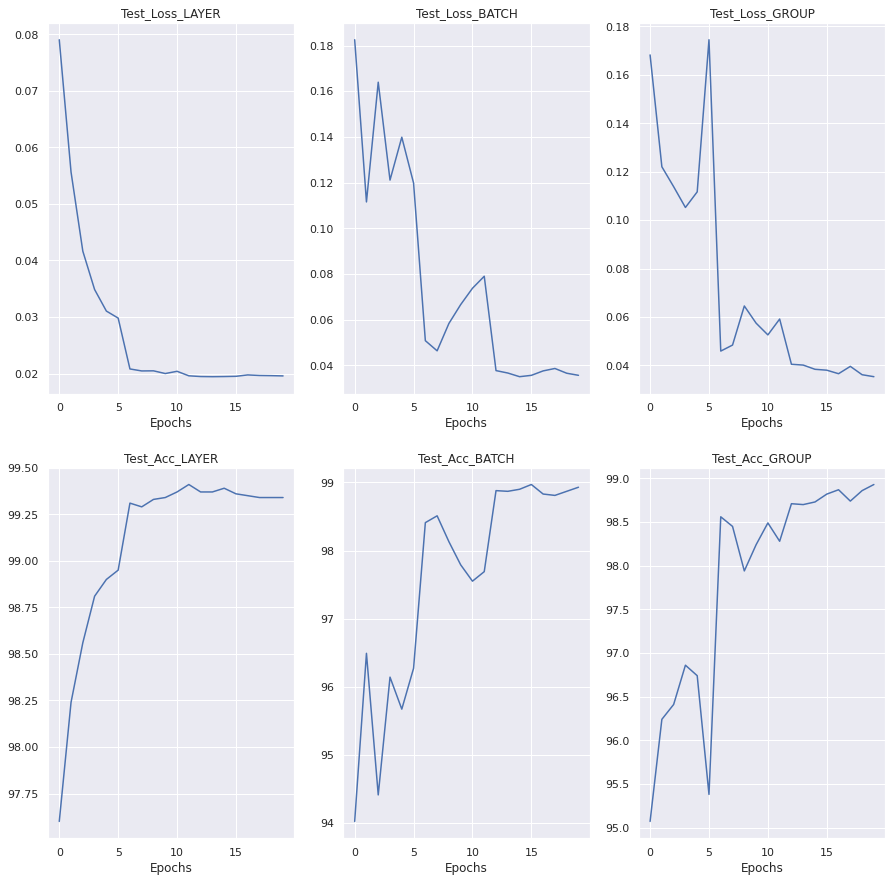

In [ ]:

## first bdirn the data to the cpu
import numpy as np
t=[t.cpu().item() for t in train_losses]
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, axs = plt.subplots(2,3,figsize=(15,15))
num_col=3
num_row=2
for i in range(num_row):
  for j in range(num_col):
    if(i==0):
      axs[i, j].plot(test_losses_dict[lstNorms[j]])
      axs[i,j].set_title("Test_Loss_"+lstNorms[j])
      #axs[i,j].set_xticks(range(0,21))

    else:
      axs[i, j].plot(test_acc_dict[lstNorms[j]])
      axs[i,j].set_title("Test_Acc_"+lstNorms[j])
    axs[i,j].set_xlabel("Epochs")  

plt.show()


     

## Checking for Misclassifications

In [ ]:
def get_misclassified(model, device, test_loader):
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients
    with torch.no_grad():
        for data, target in test_loader:
            # move them to the respective device
            data, target = data.to(device), target.to(device)
            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)

    # group all the batched together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))
     

In [ ]:
def plotMisclassified(misclassified):
  import seaborn as sns
  import matplotlib.pyplot as plt
  num_images = 10
  num_row=5
  num_col=2
  #fig = plt.figure()
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
      image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
      # ax = fig.add_subplot(2, 5, idx+1)
      ax=axes[idx//num_col, idx%num_col]
      ax.axis('off')

      ax.set_title('\ntarget {},pred {}'.format(target.item(), pred.item()), fontsize=10)
      ax.imshow(image,interpolation='bilinear')
      ax.axis('off')
  #plt.tight_layout()
  #plt.figure(12,12)
  plt.show()

Getting Misclassifications for the Model with Norm  LAYER


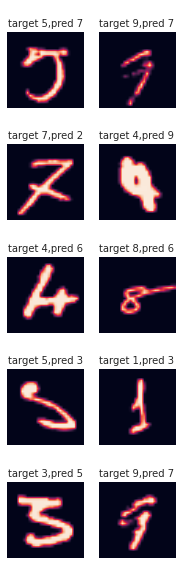

********************************
Getting Misclassifications for the Model with Norm  BATCH


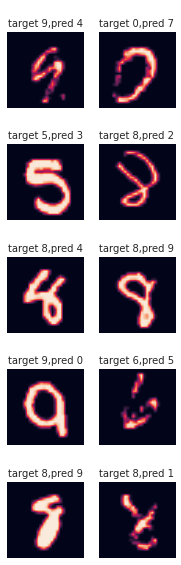

********************************
Getting Misclassifications for the Model with Norm  GROUP


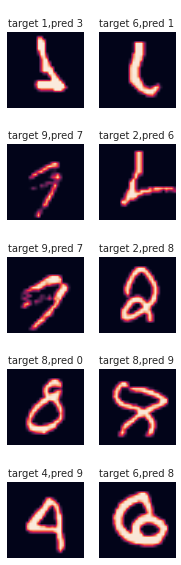

********************************


In [ ]:
for norm in lstNorms:
  print("Getting Misclassifications for the Model with Norm ",norm)
  model=torch.load("/content/drive/MyDrive/Colab_Notebooks/EVA8/normalizationTechniques/Models/"+modelNamePrefix+"_"+norm)
  misclassified = get_misclassified(model, device, test_loader)
  plotMisclassified(misclassified)
  print("********************************")
